# Johan Hedenström
Exploration

In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import matplotlib.pyplot as plt

from utils.preprocess import load_tof, Phi
from utils.plot import plot_predictions, make_palette
from image_processing import process

from models.mixture import MixIRLS

In [2]:
def add_bias(X):
    return np.c_[np.ones(len(X)), X]

In [3]:
FILE_PATH = '../data/tof_erda/raw/I_36MeV_SH2-3_SiC-ref.lst' #'../data/tof_erda/raw/I_36MeV_SH2-1_TiN-ref.lst'
X, y, phi = load_tof(FILE_PATH)
X, y = process(X,y, noise_sensitivity=0.9)
phi = Phi(X)
data = np.vstack([X,y,phi.flatten()]).T
data = np.unique(data, axis=0)
X, y, phi = data[:,0], data[:,1], data[:,2]

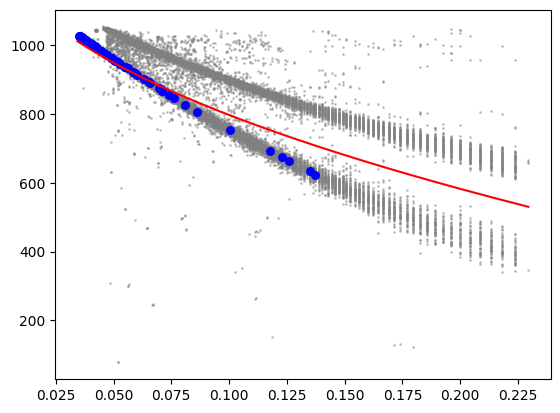

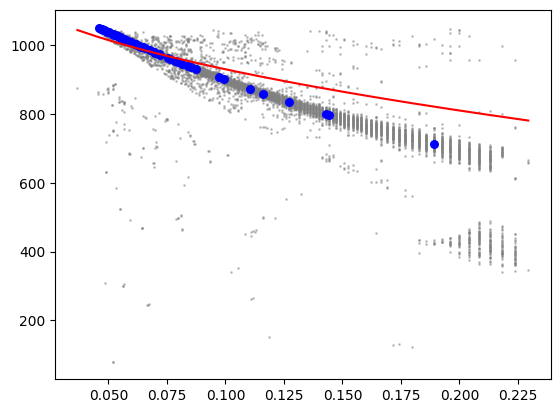

[[ 1314.9923925   1219.04441715]
 [   -0.            -0.        ]
 [   -0.            -0.        ]
 [-1638.36458833  -914.99826734]
 [   -0.            -0.        ]
 [   -0.            -0.        ]
 [   -0.            -0.        ]
 [   -0.            -0.        ]
 [   -0.            -0.        ]
 [   -0.            -0.        ]
 [   -0.            -0.        ]
 [   -0.            -0.        ]
 [   -0.            -0.        ]
 [   -0.            -0.        ]
 [   -0.            -0.        ]
 [   -0.            -0.        ]
 [   -0.            -0.        ]
 [   -0.             0.        ]
 [    0.             0.        ]
 [    0.             0.        ]
 [    0.             0.        ]
 [    0.             0.        ]
 [    0.             0.        ]
 [    0.             0.        ]
 [    0.             0.        ]
 [    0.             0.        ]
 [    0.             0.        ]
 [    0.             0.        ]
 [    0.             0.        ]]


In [4]:
K = 2
wfun = lambda r: 1 / (1+r**2)
plot = True
alpha = 1

model = MixIRLS(K=K, wfun=wfun, plot=plot, alpha=alpha)

exponents = [-1/i for i in range(2, 30)]
phi = Phi(X, exponents)

sprim, supports, iter = model.train(phi, y)
y_pred = model.predict(phi)
print(model.beta)

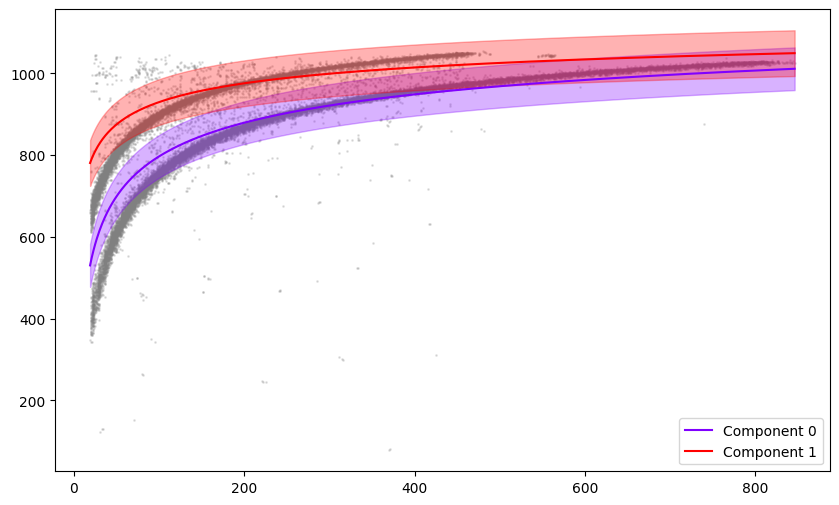

Points in support for component 0:  21069
  Number of points in component 0:  58


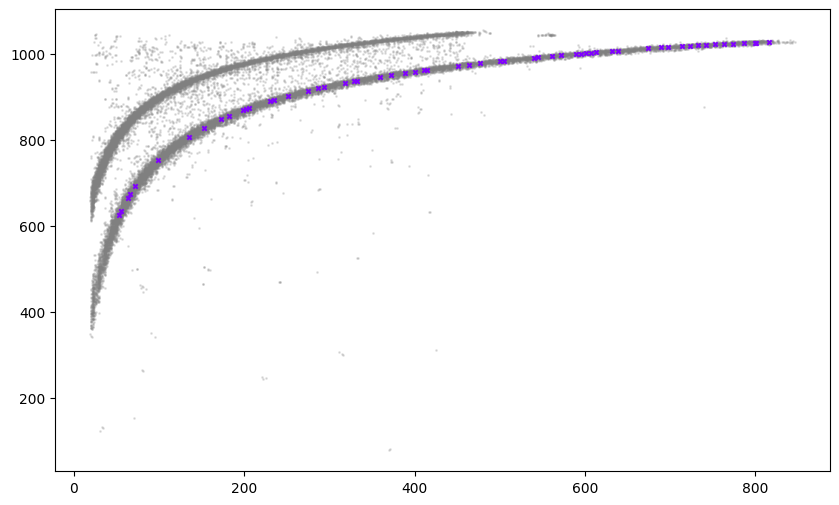

Points in support for component 1:  8096
  Number of points in component 1:  58


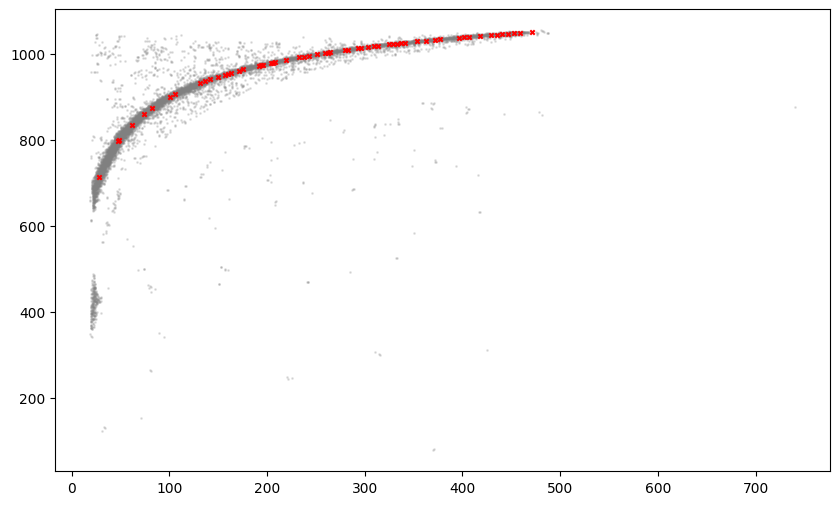

In [5]:
colors = make_palette(K)
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.2, color='grey', s=1)
for k in range(K):
    i = sprim[k]
    # Plot component points
    #plt.scatter(X[i], y[i], alpha=0.3, color=colors[k], s=1, label=f"Component {s}")
    
    # Sort based on X values but keep track of indices
    sort_idx = np.argsort(X)
    
    PHI = Phi(X[sort_idx], exponents)
    pred = model.predict_k(PHI, k)
    # Plot prediction line against sorted X[sort_idx]
    plt.plot(X[sort_idx], pred, color=colors[k], label=f"Component {k}")
    plt.fill_between(X[sort_idx], 
                            pred - 2*np.sqrt(model.sigma[k]), 
                            pred + 2*np.sqrt(model.sigma[k]), 
                            color=colors[k],
                            alpha=0.3)
    
plt.legend()
plt.show()


for k in range(K):
    
    i = supports[:,k] # points that were considered
    j = sprim[k] # points that were trained on, relative to support
    sort_idx = np.argsort(X[i])

    print(f"Points in support for component {k}: ", i.sum())
    print(f"  Number of points in component {k}: ", len(X[i][j]))
    
    plt.figure(figsize=(10, 6))
    plt.scatter(X[i], y[i], alpha=0.2, s=1, color='grey')
    plt.scatter(X[i][j], y[i][j], alpha=1, s=10, marker='x',  color=colors[k])

    # Calculate predictions using sorted phi
    #PHI = add_bias(Phi(X[i][sort_idx], exponents))
    #PRED = model.predict_k(PHI, k)
    
    # Plot prediction line against sorted X
    #plt.plot(PHI[i][sort_idx], PRED, color=colors[s], label=f"Component {s}")
    #plt.fill_between(X[i][sort_idx], 
    #                        PRED - 2*np.sqrt(sigma[s]), 
    #                        PRED + 2*np.sqrt(sigma[s]), 
    #                        color=colors[s],
    #                        alpha=0.3)
    plt.show()

Fitted parameters: a = 4772.375578919581, b = 18.139650038522696, c = 1192.4160315826064
R^2 for dataset 0: 0.9999
Fitted parameters: a = 3191.8793410250028, b = 16.403691707607635, c = 1193.7076852620241
R^2 for dataset 1: 0.9999


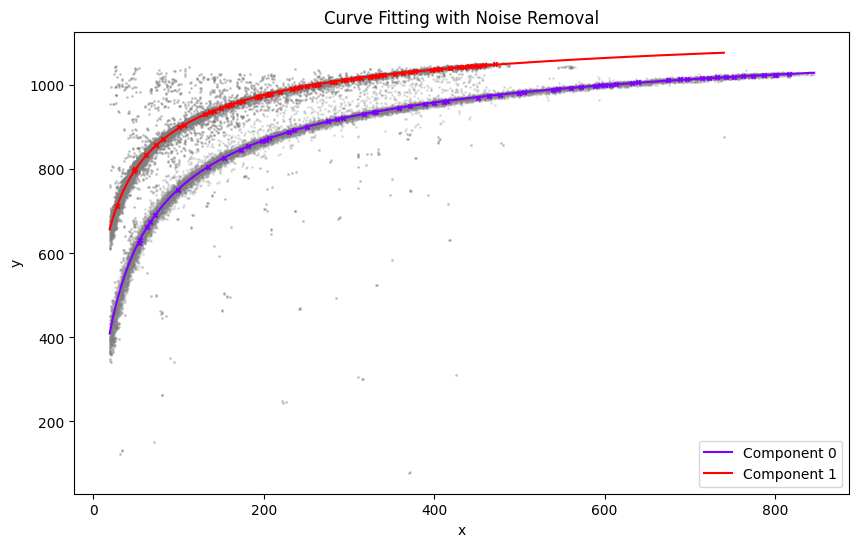

In [6]:
from scipy.optimize import curve_fit
import numpy as np
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

# Trajectory model
def trajectory_formula(x, a, b, c):
    return -abs(a) / np.sqrt(abs(x + b)) + c

# Approximate distance (point-to-trajectory)
def perpendicular_distance(x, y, a, b, c):
    predicted_y = trajectory_formula(x, a, b, c)
    slope = -a / (2 * (x + b)**(3/2))
    perp_dist = np.abs(y - predicted_y) / np.sqrt(1 + slope**2)
    return perp_dist

plt.figure(figsize=(10, 6))

for k in range(K):
    i = supports[:, k]  # Points that were considered
    j = sprim[k]  # Points that were trained on, relative to support
    sort_idx = np.argsort(X[i])

    x_data = X[i][j]
    y_data = y[i][j]

    plt.scatter(X[i], y[i], alpha=0.2, s=1, color='grey')
    plt.scatter(X[i][j], y[i][j], alpha=1, s=10, marker='x', color=colors[k])

    # Initial guesses for parameters a, b, and c
    initial_guesses = [1, 1, 1]

    # Perform curve fit
    params, covariance = curve_fit(trajectory_formula, 
                                   x_data, 
                                   y_data,
                                   bounds=([0, 0, -np.inf], [np.inf, 50, np.inf]),
                                   p0=initial_guesses)
    
    a_fit, b_fit, c_fit = params

    # Generate fitted curve
    x_fit = np.linspace(min(X[i]), max(X[i]), 500)
    y_fit = trajectory_formula(x_fit, a_fit, b_fit, c_fit)

    # Calculate R2
    y_pred = trajectory_formula(x_data, a_fit, b_fit, c_fit)  # Predicted values
    residuals = y_data - y_pred
    RSS = np.sum(residuals**2)
    TSS = np.sum((y_data - np.mean(y_data))**2)
    R2 = 1 - (RSS / TSS)

    print(f"Fitted parameters: a = {a_fit}, b = {b_fit}, c = {c_fit}")
    print(f"R^2 for dataset {k}: {R2:.4f}")

    if R2 < 0.99:
        print("Curve has bad fit, re-computing...")
        
        # Compute distances from trajectory
        perp_distances = perpendicular_distance(X[i], y[i], a_fit, b_fit, c_fit)
        
        # Histogram of X values weighted by density
        density, bin_edges = np.histogram(X[i], bins=50, weights=1 / (1 + perp_distances))
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Identify valley (local minimum in density)
        valley_index = np.argmin(density[:len(density) // 2])  # Look only in the first half of the data
        valley_x = bin_centers[valley_index]
        print(f"Identified valley at X = {valley_x}")

        # Filter out points with X values below the valley
        valid_indices = x_data >= valley_x
        x_data_filtered = x_data[valid_indices]
        y_data_filtered = y_data[valid_indices]

        # Re-fit the curve with filtered data
        params, covariance = curve_fit(trajectory_formula, 
                                       x_data_filtered, 
                                       y_data_filtered, 
                                       bounds=([0, -100, -np.inf], [np.inf, 100, np.inf]),
                                       p0=initial_guesses)
        a_fit, b_fit, c_fit = params

        x_fit = np.linspace(min(X[i]), max(X[i]), 500)
        y_fit = trajectory_formula(x_fit, a_fit, b_fit, c_fit)

    # Plot the fitted curve
    plt.plot(x_fit, y_fit, color=colors[k], label=f"Component {k}")

# Plot the data and the fitted curve
plt.xlabel('x')
plt.ylabel('y')
plt.title('Curve Fitting with Noise Removal')
plt.legend()
plt.show()


Fitted parameters: a = 4772.375578919581, b = 18.139650038522696, c = 1192.4160315826064
R^2 for dataset 0: 0.9999
Fitted parameters: a = 3191.8793410250028, b = 16.403691707607635, c = 1193.7076852620241
R^2 for dataset 1: 0.9999


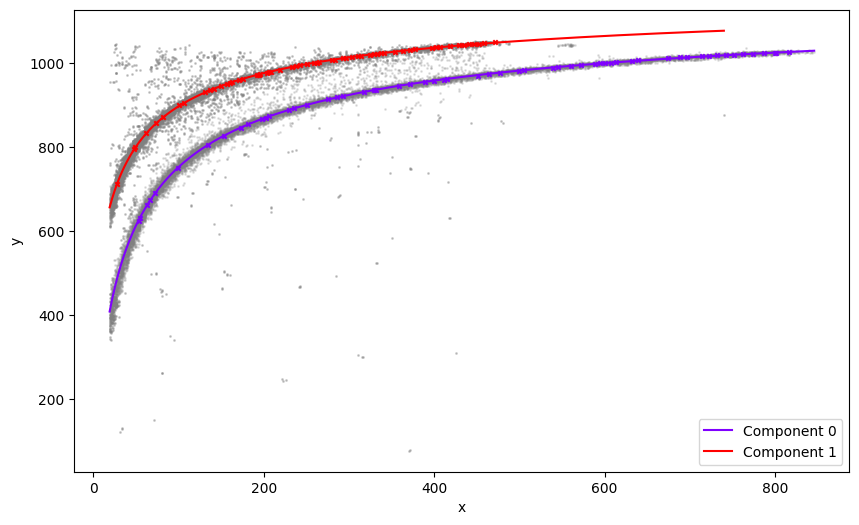

In [14]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Trajectory model
def trajectory_formula(x, a, b, c):
    return -abs(a) / np.sqrt(abs(x + b)) + c

# Approximate distance (point-to-trajectory)
def perpendicular_distance(x, y, a, b, c):
    predicted_y = trajectory_formula(x, a, b, c)
    slope = -a / (2 * (x + b)**(3/2))
    perp_dist = np.abs(y - predicted_y) / np.sqrt(1 + slope**2)
    return y - predicted_y  # Return signed deviations for empirical confidence

plt.figure(figsize=(10, 6))

for k in range(K):
    i = supports[:, k]  # Points in the cluster
    j = sprim[k]  # Points used for fitting
    sort_idx = np.argsort(X[i])

    x_data = X[i][j]
    y_data = y[i][j]

    plt.scatter(X[i], y[i], alpha=0.2, s=1, color='grey')
    plt.scatter(X[i][j], y[i][j], alpha=1, s=10, marker='x', color=colors[k])

    # Initial guesses for parameters a, b, and c
    initial_guesses = [1, 1, 1]

    # Perform curve fit
    params, covariance = curve_fit(trajectory_formula, 
                                   x_data, 
                                   y_data,
                                   bounds=([0, 0, -np.inf], [np.inf, 50, np.inf]),
                                   p0=initial_guesses)

    a_fit, b_fit, c_fit = params

    # Generate fitted curve
    x_fit = np.linspace(min(X[i]), max(X[i]), 500)
    y_fit = trajectory_formula(x_fit, a_fit, b_fit, c_fit)

    # Calculate R2
    y_pred = trajectory_formula(x_data, a_fit, b_fit, c_fit)
    residuals = y_data - y_pred
    RSS = np.sum(residuals**2)
    TSS = np.sum((y_data - np.mean(y_data))**2)
    R2 = 1 - (RSS / TSS)

    print(f"Fitted parameters: a = {a_fit}, b = {b_fit}, c = {c_fit}")
    print(f"R^2 for dataset {k}: {R2:.4f}")

    if R2 < 0.99:
        print("Curve has bad fit, re-computing...")
        
        # Compute distances from trajectory
        perp_distances = perpendicular_distance(X[i], y[i], a_fit, b_fit, c_fit)
        
        # Histogram of X values weighted by density
        density, bin_edges = np.histogram(X[i], bins=50, weights=1 / (1 + perp_distances))
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Identify valley (local minimum in density)
        valley_index = np.argmin(density[:len(density) // 2])  # Look only in the first half of the data
        valley_x = bin_centers[valley_index]
        print(f"Identified valley at X = {valley_x}")

        # Filter out points with X values below the valley
        valid_indices = x_data >= valley_x
        x_data_filtered = x_data[valid_indices]
        y_data_filtered = y_data[valid_indices]

        # Re-fit the curve with filtered data
        params, covariance = curve_fit(trajectory_formula, 
                                       x_data_filtered, 
                                       y_data_filtered, 
                                       bounds=([0, -100, -np.inf], [np.inf, 100, np.inf]),
                                       p0=initial_guesses)
        a_fit, b_fit, c_fit = params

        x_fit = np.linspace(min(X[i]), max(X[i]), 500)
        y_fit = trajectory_formula(x_fit, a_fit, b_fit, c_fit)

    plt.plot(x_fit, y_fit, color=colors[k], label=f"Component {k}")

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


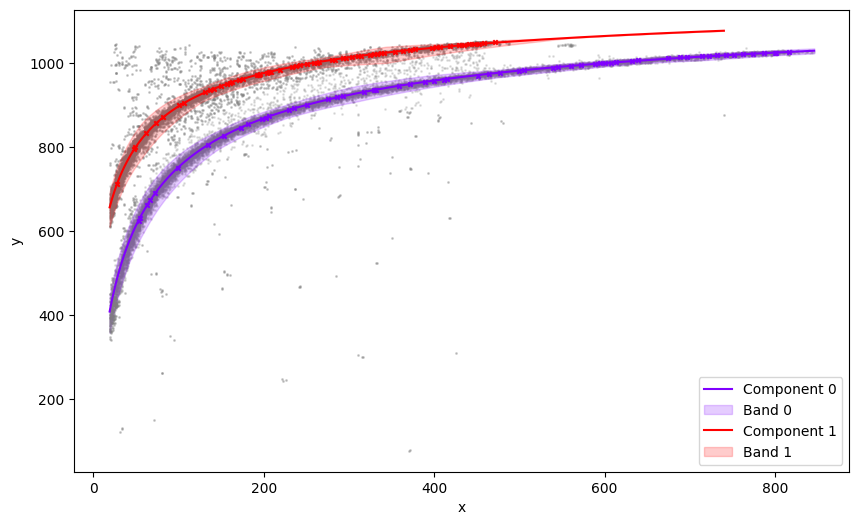

In [64]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Trajectory model
def trajectory_formula(x, a, b, c):
    return -abs(a) / np.sqrt(abs(x + b)) + c

# Vertical distance from point to curve
def compute_deviations(x, y, a, b, c):
    fitted_y = trajectory_formula(x, a, b, c)
    deviations = y - fitted_y
    return deviations

plt.figure(figsize=(10, 6))

for k in range(K):
    i = supports[:, k]  # Points in the cluster
    j = sprim[k]  # Points used for fitting

    x_data = X[i][j]
    y_data = y[i][j]

    # Scatter plot for cluster points
    plt.scatter(X[i], y[i], alpha=0.2, s=1, color='grey')
    plt.scatter(x_data, y_data, alpha=1, s=10, marker='x', color=colors[k])

    # Initial guesses for parameters a, b, and c
    initial_guesses = [1, 1, 1]

    # Perform curve fit
    params, covariance = curve_fit(trajectory_formula, 
                                   x_data, 
                                   y_data,
                                   bounds=([0, 0, -np.inf], [np.inf, 50, np.inf]),
                                   p0=initial_guesses)

    a_fit, b_fit, c_fit = params

    # Generate fitted curve
    x_fit = np.linspace(min(X[i]), max(X[i]), 500)
    y_fit = trajectory_formula(x_fit, a_fit, b_fit, c_fit)

    # Compute deviations
    deviations = compute_deviations(X[i], y[i], a_fit, b_fit, c_fit)

    # Divide data into bins along x
    num_bins = 10
    bins = np.linspace(min(X[i]), max(X[i]), num_bins + 1)
    lower_bound_values = []
    upper_bound_values = []
    bin_centers = []

    # Iterate through each bin
    for b_start, b_end in zip(bins[:-1], bins[1:]):
        # Extract points in the bin
        bin_indices = (X[i] >= b_start) & (X[i] < b_end)
        bin_deviations = deviations[bin_indices]
        
        if len(bin_deviations) > 5:
            # Create histogram of deviations
            density, bin_edges = np.histogram(bin_deviations, bins=100, density=True)
            bin_centers_dev = (bin_edges[:-1] + bin_edges[1:]) / 2

            # Find peak and valleys
            peak_index = np.argmax(density)
            left_valley_index = np.where(density[:peak_index] < density[peak_index] * 0.1)[0]
            right_valley_index = np.where(density[peak_index:] < density[peak_index] * 0.1)[0]

            left_valley = (
                bin_centers_dev[left_valley_index[-1]] if len(left_valley_index) > 0 else bin_centers_dev[0]
            )
            right_valley = (
                bin_centers_dev[peak_index + right_valley_index[0]] if len(right_valley_index) > 0 else bin_centers_dev[-1]
            )

            lower_bound_values.append(left_valley)
            upper_bound_values.append(right_valley)
            bin_centers.append((b_start + b_end) / 2)
        else:
            lower_bound_values.append(0)
            upper_bound_values.append(0)
            bin_centers.append((b_start + b_end) / 2)

    # Interpolate the bounds to smooth transitions
    lower_bound_interp = np.interp(x_fit, bin_centers, lower_bound_values)
    upper_bound_interp = np.interp(x_fit, bin_centers, upper_bound_values)

    # Compute bounds
    y_lower_bound = trajectory_formula(x_fit, a_fit, b_fit, c_fit) + lower_bound_interp
    y_upper_bound = trajectory_formula(x_fit, a_fit, b_fit, c_fit) + upper_bound_interp

    # Force bounds to include fitted curve
    y_lower_bound = np.minimum(y_lower_bound, y_fit)
    y_upper_bound = np.maximum(y_upper_bound, y_fit)

    # Plot fitted curve and bands
    plt.plot(x_fit, y_fit, color=colors[k], label=f"Component {k}")
    plt.fill_between(x_fit, y_lower_bound, y_upper_bound, color=colors[k], alpha=0.2, label=f"Band {k}")

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
